<a href="https://colab.research.google.com/github/hsiangwei0903/Fine-Grained-Object-Recognition/blob/dev%2Fravi%2Ftent/TrainingAndTent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [72]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
import numpy as np
%matplotlib inline

In [3]:
cd /content/drive/My Drive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/

/content/drive/.shortcut-targets-by-id/1beXLuTyfFnOo3t19p65wHXF-qaxghvjI/ENGINE: Wyze


In [4]:
dataset = ImageFolder('./Images/stanfordImages/Images')

In [5]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

In [6]:
len(dataset)


20580

In [7]:
random_seed = 45
torch.manual_seed(random_seed);
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(12966, 1440, 6174)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(12966, 1440, 6174)

n02107908-Appenzeller
<class 'PIL.Image.Image'>


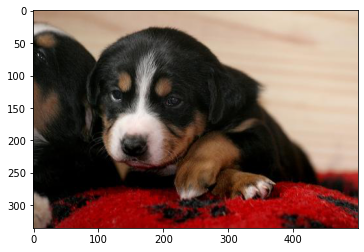

In [9]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [10]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [11]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),    
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [12]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

89


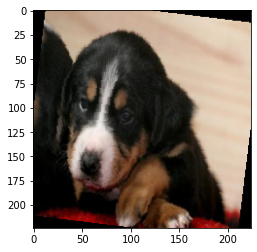

In [13]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [14]:
batch_size =64

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [15]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

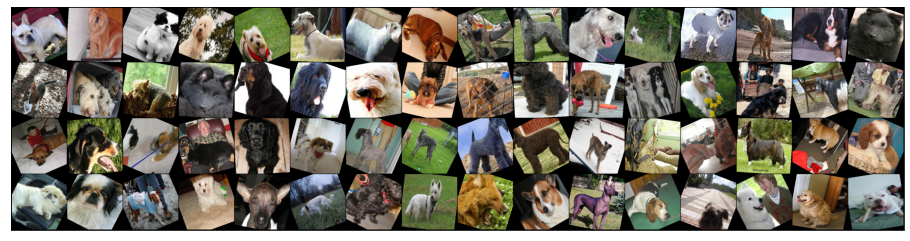

In [16]:
show_batch(train_dl)


In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    # print(outputs[0])
    # print(preds[0])
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [18]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        # print(out[0])
        # print(targets[0])
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [19]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [20]:
model2 = DogBreedPretrainedResnet34()
model2

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

DogBreedPretrainedResnet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [21]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [22]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [23]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


# moving model to gpu
to_device(model2, device);

cuda


In [24]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model2(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([ 22,  80, 104,  28, 115,  55,  30,  73,   4,  89,  11,  81, 117,  77,
        117, 104,  68,  87, 106,  59, 100, 112, 107,  48,  94,   1,  38, 116,
         12,   2,  90,  26,  24,  37,  32,  32,   4,  75,  74,  17,  11,   5,
        119,  78,  84,  89,  20,  19,  14, 116,  58,  24,  51,  85,  94,  39,
          9,  83, 104,  27,   9, 106,  61,  74], device='cuda:0')
outs.shape : torch.Size([64, 120])
outs :  tensor([[-6.3830, -5.7007, -6.6832,  ..., -5.6179, -5.1419, -4.5257],
        [-4.2547, -5.3520, -8.0733,  ..., -5.6066, -5.1789, -4.8977],
        [-5.6847, -6.1818, -6.3412,  ..., -5.2518, -5.5608, -5.2439],
        ...,
        [-6.0338, -5.5939, -6.1744,  ..., -5.2257, -5.4709, -4.8144],
        [-5.1867, -5.5498, -6.6443,  ..., -5.6208, -5.7446, -4.5046],
        [-5.4211, -4.4552, -6.4409,  ..., -4.8101, -4.7563, -5.2719]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [25]:
from tqdm.notebook import tqdm


In [26]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    for batch in val_loader:
      outputs = [model.validation_step(batch) for batch in val_loader]
      return model.validation_epoch_end(outputs)

In [27]:
evaluate(model2, val_dl)                 # change model object here


{'val_acc': 0.010416666977107525, 'val_loss': 5.057640075683594}

In [271]:
# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, weight_decay, grad_clip, opt_func)


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.4091, val_loss: 1.5662, val_acc: 0.6315


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 1.1108, val_loss: 1.1450, val_acc: 0.6693


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.8600, val_loss: 1.3438, val_acc: 0.6354


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.7124, val_loss: 1.2572, val_acc: 0.6413


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.5855, val_loss: 1.0753, val_acc: 0.6875


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.4558, val_loss: 1.0308, val_acc: 0.7044


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.3292, val_loss: 0.9257, val_acc: 0.7246


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.2177, val_loss: 0.8238, val_acc: 0.7526


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [8] : train_loss: 0.1447, val_loss: 0.7533, val_acc: 0.7786


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [9] : train_loss: 0.1138, val_loss: 0.7487, val_acc: 0.7819


In [ ]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.1116, val_loss: 0.7432, val_acc: 0.7806


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.1077, val_loss: 0.7479, val_acc: 0.7767


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0995, val_loss: 0.7402, val_acc: 0.7767


In [ ]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model2, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0985, val_loss: 0.7399, val_acc: 0.7754


  0%|          | 0/203 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0974, val_loss: 0.7355, val_acc: 0.7806


In [ ]:
weights_fname = 'dog-breed-classifier-resnet34-pretrained-finetuned.pth'
torch.save(model2.state_dict(), weights_fname)

In [ ]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [ ]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

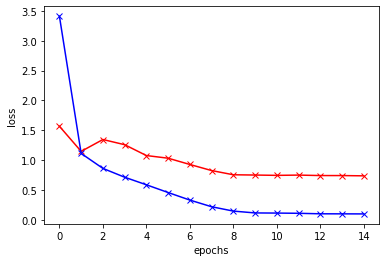

In [ ]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

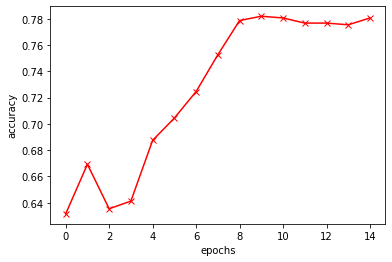

In [ ]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [28]:
saved_model = DogBreedPretrainedResnet34()
saved_model.load_state_dict(torch.load("/content/drive/MyDrive/UW/2021-22_Senior/Capstone/ENGINE: Wyze/dog-breed-classifier-resnet34-pretrained-finetuned.pth"))

<All keys matched successfully>

In [29]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


# moving model to gpu
to_device(saved_model, device);

cuda


In [ ]:
evaluate(saved_model, test_dl) 

{'val_acc': 0.7861713767051697, 'val_loss': 0.7101448774337769}

In [46]:
our_dataset = ImageFolder('./Images/test')

In [65]:
our_dataset.classes

['n02085620-Chihuahua',
 'n02091032-Italian_greyhound',
 'n02093428-American_Staffordshire_terrier',
 'n02097047-miniature_schnauzer',
 'n02099712-Labrador_retriever',
 'n02106662-German_shepherd',
 'n02107142-Doberman',
 'n02110063-malamute',
 'n02110185-Siberian_husky',
 'n02113799-standard_poodle']

In [47]:
len(our_dataset)


88

n02085620-Chihuahua
<class 'PIL.Image.Image'>


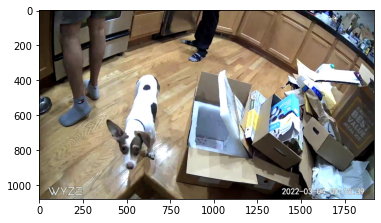

In [48]:
img, label = our_dataset[6]
print(our_dataset.classes[label])
plt.imshow(img)
print(type(img))

In [64]:
wyze_dataset = DogBreedDataset(our_dataset, test_transform)
len(wyze_dataset)


AttributeError: ignored

0


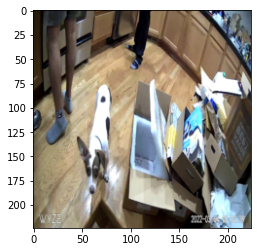

In [50]:
img, label = wyze_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [61]:
wyze_dl = DataLoader(wyze_dataset, 90, num_workers = 2, pin_memory = True)

In [62]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
wyze_dl = DeviceDataLoader(wyze_dl, device)


# moving model to gpu
to_device(saved_model, device);

cuda


In [75]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = saved_model(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        _, preds = torch.max(outs, dim=1)
        print(preds)
        print("preds.shape: ", preds.shape)
        
        labelslist = labels.detach().tolist()
        print(labelslist)
        predlist = preds.detach().tolist()
        print(predlist)

        labelslist = [our_dataset.classes[i] for i in labelslist]
        print(labelslist)
        predlist = [dataset.classes[i] for i in predlist]
        print(predlist)
        
        labelsarray = np.array(labelslist)
        predarray = np.array(predlist)
        print(((np.sum(labelsarray == predarray)) / 88) * 100)
        break
        
try_batch(wyze_dl)

images shape :  torch.Size([88, 3, 224, 224])
labels :  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
outs.shape : torch.Size([88, 120])
outs :  tensor([[-4.0909, -7.0365, -5.3397,  ..., -6.1961, -5.4080, -8.4631],
        [-4.6139, -7.2726, -4.7487,  ..., -7.0293, -7.8354, -9.8651],
        [-4.4228, -7.0960, -6.0878,  ..., -6.3466, -5.8761, -9.7243],
        ...,
        [-6.0947, -7.6185, -4.2653,  ..., -6.5811, -7.4134, -7.7760],
        [-5.3994, -7.5097, -3.6621,  ..., -8.2624, -8.7785, -8.5639],
        [-7.9725, -7.4210, -7.8547,  ..., -7.6379, -8.5064, -7.3056]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([101,   4,  44,  11, 101,  53,  53,  36, 111, 111,  20,  35,  27,   7,
         57,  22,  3

In [235]:
evaluate(saved_model, wyze_dl)

{'val_acc': 0.9882234930992126, 'val_loss': 0.07134025543928146}

IndexError: ignored